# Models IX: ANOVA and additional comparisons

**Note:**  
Before running this notebook open a terminal, activate the `201b` environment, and install the `marginaleffects` package:

1. Open terminal
2. `conda activate 201b`
3. `pip install marginaleffects`

Let's keep working with the *poker dataset* from the previous notebook and explore models how we can ask **additional questions** about the data

The experiments used a 2 (skill) x 3 (hand) x 2 (limit) design

| Variable   | Description                     |
|------------|---------------------------------|
| skill     | a player's skill (expert/average)|
| hand     | the quality of the hand experimenters manipulate (bad/neutral/good)|
| limit     | the style of game (fixed/no-limit)|
| balance     | a player's final balance in Euros|

**Slides for reference**

[Modeling VII](https://stat-intuitions.com/lectures/wk8/1.html)

Let's start by loading the data, plotting the **interaction effect** of `hand` and `skill` on `balance`, and estimating our **valid two-way ANOVA**

In [1]:
import numpy as np
import polars as pl
from polars import col
from polars import when, lit
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Load data
df = pl.read_csv('./data/poker-tidy.csv')

In [2]:
# Sum code our categorical variables because sum coding is a valid contrast for ANOVA
model = ols("balance ~ C(hand, Sum) * C(skill, Sum)", data=df.to_pandas())

# Estimate model
results = model.fit()

In [3]:
# Use type III SS to calculate F-stats for main effects and interactions
anova_lm(results, typ=3).round(4)

sum_sq     df          F  PR(>F)
Intercept                   28644.6637    1.0  1772.1137  0.0000
C(hand, Sum)                 2559.4014    2.0    79.1692  0.0000
C(skill, Sum)                  39.3494    1.0     2.4344  0.1198
C(hand, Sum):C(skill, Sum)    228.9817    2.0     7.0830  0.0010
Residual                     4752.2521  294.0        NaN     NaN

## Unpacking the ANOVA

Whenever we're running an ANOVA we need to make a distinction between **main effects** and **simple effects** that doesn't come up when we're using *continuous* predictors. Remember that the F-tests in the output above are **omnibus** or *joint-tests* - they tell us whether factor as a whole matters, *not* which specific factor levels are different:  

- **main effect**: effect of *entire* independent variable (IV) e.g. `hand` on dependent variable (DV)
- **interaction effect**: when the *main effect* of one IV depends upon the levels of *another* IV e.g. `skill`
- **simple effect**: comparisons between *specific levels* of an IV - i.e. "cell means" comparisons, e.g. `good` vs `bad` within `hand`

Above we see a significant interaction which we can interpret as *differences between differences*:
- the difference between levels of `hand` are different across levels of `skill`
- OR the difference between levels of `skill` are different across levels of `hand`

But **what specific differences**? Let's explore two ways we can test more specific hypotheses:

### "Post-hoc" pairwise cell-mean comparisons

The simplest approach we can take is to use "post-hoc" pairwise comparisons. We say this is **post-hoc** because we're testing **additional hypotheses after our main model**. 

The most common way to do this is to perform "pairwise" comparisons: comparisons between **every pair of cell means**, i.e. every combination of levels of the two factors: 


In [4]:
# Calculate cell means for each combination of factor levels
cell_means = df.group_by(['hand','skill']).agg(
    col('balance').mean()).sort(['hand','skill'])

cell_means

shape: (6, 3)
┌─────────┬─────────┬─────────┐
│ hand    ┆ skill   ┆ balance │
│ ---     ┆ ---     ┆ ---     │
│ str     ┆ str     ┆ f64     │
╞═════════╪═════════╪═════════╡
│ bad     ┆ average ┆ 4.5866  │
│ bad     ┆ expert  ┆ 7.2964  │
│ good    ┆ average ┆ 13.7976 │
│ good    ┆ expert  ┆ 12.2552 │
│ neutral ┆ average ┆ 9.8438  │
│ neutral ┆ expert  ┆ 10.8494 │
└─────────┴─────────┴─────────┘

Visually, you can think about that as directly comparing each individual box in the boxplot above to every other box

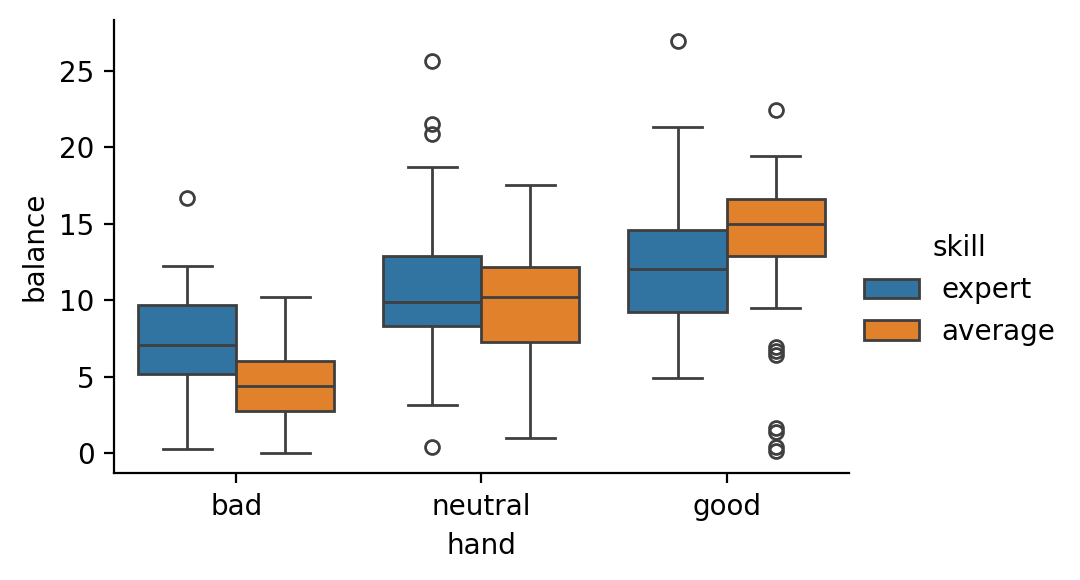

In [5]:
# Our box plot shows the mean of each cell
grid = sns.catplot(data=df, x='hand', y='balance',hue='skill', kind='box', height=3, aspect=1.5)



Because these comparisons are no longer *independent*, we have to adjust our *alpha* level which - **raise the threshold** at which we decide to reject the null hypothesis based upon our p-value. In other words decrease, our typical threshold of `p < .05` where `alpha = .05` to `p < new_alpha`, where `new_alpha` is something *smaller* than `.05`. 

This idea, called **multiple comparisons correction**, comes in may flavors with the same underlying goal: reduce the number of *false positive* results we find while minimizing the number of *false negative* results we don't find.

Three of the most common approaches from most to least strict (in terms of false positives at the expense of false negatives):

1. Bonferroni = `alpha / n` - we just adjust our p-value threshold to smaller for each comparison we run
    - 1 test: alpha = .05
    - 2 tests: alpha = .05 / 2 = .025
    - 3 tests: alpha = .05 / 3 = .0167
    - Most conservative (fewest false positives); but also most stringent (most false negatives)
2. Holm-Bonferroni = "sequential" bonferroni - we adjust our p-value threshold to smaller for each comparison we run, but we also adjust the threshold for the next comparison to be smaller than the previous one
    - Much better balanced than Bonferroni when we have lots of comparisons to make
3. False discovery rate (FDR) - we adjust our alpha threshold based upon the size of our p-values, such that we apply Bonferroni correction to the smallest p-value we find and apply a less stringest correction for the next smallest p-value, etc
    - Ideal when the number of comparisons is very large; but also increases false positive rate


### Instructor's Note

*Performing custom cell mean comparisons are a bit easier in R thanks to the `emmeans` package, which doesn't have a perfect counter-part in Python 😢.*  
*In one more week, when we discuss repeated-measures/multi-level models (`lmer` in R), things will get a bit easier because we'll use a Python package that **does** supports `emmeans` like functionality.*

*For now, we'll show you a few different ways perform these comparisons in Python, each with their own pros and cons.*

#### Within factor comparisions using `statsmodels`

Main approach: 
- Use `.t_test_pairwise()` method on the results of your model (i.e. the output of `.fit()`)

Pros
- No additional libraries needed
- Straightforward to use
- Built-in support for multiple comparisons correction

Cons
- Need to name variables **exactly** like they are in your model's formula
- Can only compare levels **within a factor**, i.e. no interactions!
- Can't get cell means easily

The first argument to the method is the name of first predictor **exactly like it appears in our model formula**, and the `method` argument provides support for a variety of multiple comparisons corrections. In our data here, we don't have that many comparisons and the differences are so large that our multiple-comparisons correction method doesn't really matter

In [10]:
# Pairwise differences of levels of hand
results.t_test_pairwise("C(hand, Sum)", method='bonferroni').result_frame

coef   std err          t         P>|t|  Conf. Int. Low  \
good-bad      7.0849  0.568579  12.460706  6.667347e-29        5.965899   
neutral-bad   4.4051  0.568579   7.747556  1.530999e-13        3.286099   
neutral-good -2.6798  0.568579  -4.713151  3.769889e-06       -3.798801   

              Conf. Int. Upp.  pvalue-bonferroni  reject-bonferroni  
good-bad             8.203901       2.000204e-28               True  
neutral-bad          5.524101       4.592996e-13               True  
neutral-good        -1.560799       1.130967e-05               True

In [11]:
# Same thing but with a more liberal correction method
results.t_test_pairwise("C(hand, Sum)", method='fdr_bh').result_frame

coef   std err          t         P>|t|  Conf. Int. Low  \
good-bad      7.0849  0.568579  12.460706  6.667347e-29        5.965899   
neutral-bad   4.4051  0.568579   7.747556  1.530999e-13        3.286099   
neutral-good -2.6798  0.568579  -4.713151  3.769889e-06       -3.798801   

              Conf. Int. Upp.  pvalue-fdr_bh  reject-fdr_bh  
good-bad             8.203901   2.000204e-28           True  
neutral-bad          5.524101   2.296498e-13           True  
neutral-good        -1.560799   3.769889e-06           True

### Challenge (mini)

Using the two examples above, use `.t_test_pairwise()` to compute the diffence between levels of `skill`

Using the original dataframe `df`, verify that the value in the `coef` column is indeed the difference between the two levels of `skill`.

In [12]:
# Your code here

In [13]:
# Solution
results.t_test_pairwise("C(skill, Sum)").result_frame

coef   std err         t     P>|t|  Conf. Int. Low  \
expert-average  0.724333  0.464243  1.560246  0.119778       -0.189328   

                Conf. Int. Upp.  pvalue-hs  reject-hs  
expert-average         1.637994   0.119778      False

#### With `marginaleffects` library

[`marginaleffects`](https://marginaleffects.com/) is a very neat library that supports both R and Python and can handle a lot of different types of marginal comparisons and estimates. Unfortunately, the Python version doesn't *yet* have *all* the features of the R version.

However, it's useful precisely because the previous approach using `.t_test_pairwise` doesn't handle comparisons between cell means across different factor levels, but `marginaleffects` does!

Main approach:
- `avg_predictions()` function for cell means
- `avg_predictions()` function with the `hypothesis` argument for pairwise comparisons


Pros
- Can refer to variables based on their column names
- Easy to get cell means and comparisons
- Supports interaction and complex pairwise comparisons (e.g. with continuous predictors)
- Support many other types of analyses
- Has a comparable R package

Cons
- Doesn't support multiple comparisons correction
- Commands (syntax) can be a little wonky
- Not all R-version features are supported in Python

We can use the `marginaleffects` package which takes our estimated model results as input and a `by` argument that is one of our predictor variables as named in our dataframe:

Marginal means of each level of `hand` (averaged across `skill`)

In [14]:
from marginaleffects import avg_predictions

avg_predictions(results, by='hand')

shape: (3, 8)
┌─────────┬──────────┬───────────┬───────────┬─────────┬─────┬───────────┬───────────┐
│ hand    ┆ Estimate ┆ Std.Error ┆ z         ┆ P(>|z|) ┆ S   ┆ 2.5%      ┆ 97.5%     │
│ ---     ┆ ---      ┆ ---       ┆ ---       ┆ ---     ┆ --- ┆ ---       ┆ ---       │
│ str     ┆ f64      ┆ f64       ┆ f64       ┆ f64     ┆ f64 ┆ f64       ┆ f64       │
╞═════════╪══════════╪═══════════╪═══════════╪═════════╪═════╪═══════════╪═══════════╡
│ bad     ┆ 5.9415   ┆ 0.402046  ┆ 14.778146 ┆ 0.0     ┆ inf ┆ 5.153504  ┆ 6.729496  │
│ good    ┆ 13.0264  ┆ 0.402047  ┆ 32.40023  ┆ 0.0     ┆ inf ┆ 12.238403 ┆ 13.814397 │
│ neutral ┆ 10.3466  ┆ 0.402046  ┆ 25.734846 ┆ 0.0     ┆ inf ┆ 9.558604  ┆ 11.134596 │
└─────────┴──────────┴───────────┴───────────┴─────────┴─────┴───────────┴───────────┘

Columns: hand, estimate, std_error, statistic, p_value, s_value, conf_low, conf_high

Marginal means of each level of `skill` (averaged across `hand`)

In [15]:
avg_predictions(results, by='skill')

shape: (2, 8)
┌─────────┬───────────┬───────────┬───────────┬─────────┬─────┬──────────┬───────────┐
│ skill   ┆ Estimate  ┆ Std.Error ┆ z         ┆ P(>|z|) ┆ S   ┆ 2.5%     ┆ 97.5%     │
│ ---     ┆ ---       ┆ ---       ┆ ---       ┆ ---     ┆ --- ┆ ---      ┆ ---       │
│ str     ┆ f64       ┆ f64       ┆ f64       ┆ f64     ┆ f64 ┆ f64      ┆ f64       │
╞═════════╪═══════════╪═══════════╪═══════════╪═════════╪═════╪══════════╪═══════════╡
│ average ┆ 9.409333  ┆ 0.32827   ┆ 28.66342  ┆ 0.0     ┆ inf ┆ 8.765936 ┆ 10.05273  │
│ expert  ┆ 10.133667 ┆ 0.32827   ┆ 30.869944 ┆ 0.0     ┆ inf ┆ 9.49027  ┆ 10.777063 │
└─────────┴───────────┴───────────┴───────────┴─────────┴─────┴──────────┴───────────┘

Columns: skill, estimate, std_error, statistic, p_value, s_value, conf_low, conf_high

We can get the individual cell means (combinations of factor levels) by passing a *list* to `by`:

In [16]:
avg_predictions(results, by=['hand','skill'])

shape: (6, 9)
┌─────────┬─────────┬──────────┬───────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ hand    ┆ skill   ┆ Estimate ┆ Std.Error ┆ … ┆ P(>|z|)    ┆ S         ┆ 2.5%      ┆ 97.5%     │
│ ---     ┆ ---     ┆ ---      ┆ ---       ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│ str     ┆ str     ┆ f64      ┆ f64       ┆   ┆ f64        ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪═════════╪══════════╪═══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ bad     ┆ average ┆ 4.5866   ┆ 0.568579  ┆ … ┆ 6.6613e-16 ┆ 50.415037 ┆ 3.472205  ┆ 5.700995  │
│ bad     ┆ expert  ┆ 7.2964   ┆ 0.568579  ┆ … ┆ 0.0        ┆ inf       ┆ 6.182005  ┆ 8.410795  │
│ good    ┆ average ┆ 13.7976  ┆ 0.568579  ┆ … ┆ 0.0        ┆ inf       ┆ 12.683205 ┆ 14.911995 │
│ good    ┆ expert  ┆ 12.2552  ┆ 0.568579  ┆ … ┆ 0.0        ┆ inf       ┆ 11.140805 ┆ 13.369595 │
│ neutral ┆ average ┆ 9.8438   ┆ 0.568579  ┆ … ┆ 0.0        ┆ inf       ┆ 8.729405  ┆ 10.958195 │
│ neutral ┆ expert  ┆ 10.8494  ┆ 0.568579  ┆ … ┆ 0.0        ┆ inf       ┆ 9.735005  ┆ 11.963795 │
└─────────┴─────────┴──────────┴───────────┴───┴────────────┴───────────┴───────────┴───────────┘

Columns: hand, skill, estimate, std_error, statistic, p_value, s_value, conf_low, conf_high

We can also add the `hypothesis = 'pairwise'` argument to any of the same commands above to calculate *differences* between the calculate marginal or cell means.

Marginal mean differences *within* levels of `hand`

In [17]:
avg_predictions(results, by='hand', hypothesis='pairwise')

shape: (3, 8)
┌──────────────┬──────────┬───────────┬───────────┬────────────┬───────────┬───────────┬───────────┐
│ Term         ┆ Estimate ┆ Std.Error ┆ z         ┆ P(>|z|)    ┆ S         ┆ 2.5%      ┆ 97.5%     │
│ ---          ┆ ---      ┆ ---       ┆ ---       ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│ str          ┆ f64      ┆ f64       ┆ f64       ┆ f64        ┆ f64       ┆ f64       ┆ f64       │
╞══════════════╪══════════╪═══════════╪═══════════╪════════════╪═══════════╪═══════════╪═══════════╡
│ bad - good   ┆ -7.0849  ┆ 0.56858   ┆ -12.4607  ┆ 0.0        ┆ inf       ┆ -8.199296 ┆ -5.970504 │
│ bad -        ┆ -4.4051  ┆ 0.568579  ┆ -7.747554 ┆ 9.3259e-15 ┆ 46.607683 ┆ -5.519495 ┆ -3.290705 │
│ neutral      ┆          ┆           ┆           ┆            ┆           ┆           ┆           │
│ good -       ┆ 2.6798   ┆ 0.56858   ┆ 4.713149  ┆ 0.000002   ┆ 18.645174 ┆ 1.565405  ┆ 3.794195  │
│ neutral      ┆          ┆           ┆           ┆            ┆           ┆           ┆           │
└──────────────┴──────────┴───────────┴───────────┴────────────┴───────────┴───────────┴───────────┘

Columns: term, estimate, std_error, statistic, p_value, s_value, conf_low, conf_high

Marginal mean differences *within* levels of `skill`

In [18]:
avg_predictions(results, by='skill', hypothesis='pairwise')

shape: (1, 8)
┌───────────┬───────────┬───────────┬───────────┬──────────┬──────────┬───────────┬──────────┐
│ Term      ┆ Estimate  ┆ Std.Error ┆ z         ┆ P(>|z|)  ┆ S        ┆ 2.5%      ┆ 97.5%    │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---      ┆ ---      ┆ ---       ┆ ---      │
│ str       ┆ f64       ┆ f64       ┆ f64       ┆ f64      ┆ f64      ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪══════════╪══════════╪═══════════╪══════════╡
│ average - ┆ -0.724333 ┆ 0.464244  ┆ -1.560243 ┆ 0.118702 ┆ 3.074579 ┆ -1.634234 ┆ 0.185568 │
│ expert    ┆           ┆           ┆           ┆          ┆          ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴──────────┴──────────┴───────────┴──────────┘

Columns: term, estimate, std_error, statistic, p_value, s_value, conf_low, conf_high

And by passing a list to `by` again along with `hypothesis` we can get the pairwise comparison between each combination of factor levels

Since we have 3 levels of `hand` (bad, good, neutral) and 2 levels of `skill` (expert, average) we have 6 unique combinations of factor levels to compare

The unique number of pairs is $n*(n-1)/2$ or in our case $6*5/2=15$

In [19]:
all_pairs = avg_predictions(results, by=['hand','skill'], hypothesis='pairwise')

all_pairs.height

15

In [20]:
all_pairs

shape: (15, 8)
┌────────────┬──────────┬───────────┬────────────┬────────────┬───────────┬────────────┬───────────┐
│ Term       ┆ Estimate ┆ Std.Error ┆ z          ┆ P(>|z|)    ┆ S         ┆ 2.5%       ┆ 97.5%     │
│ ---        ┆ ---      ┆ ---       ┆ ---        ┆ ---        ┆ ---       ┆ ---        ┆ ---       │
│ str        ┆ f64      ┆ f64       ┆ f64        ┆ f64        ┆ f64       ┆ f64        ┆ f64       │
╞════════════╪══════════╪═══════════╪════════════╪════════════╪═══════════╪════════════╪═══════════╡
│ bad,       ┆ -2.7098  ┆ 0.804093  ┆ -3.370009  ┆ 0.000752   ┆ 10.377639 ┆ -4.285793  ┆ -1.133807 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ expert     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆ -9.211   ┆ 0.804093  ┆ -11.455149 ┆ 0.0        ┆ inf       ┆ -10.786992 ┆ -7.635008 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ good,      ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ average    ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆ -7.6686  ┆ 0.804093  ┆ -9.536958  ┆ 0.0        ┆ inf       ┆ -9.244593  ┆ -6.092607 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ good,      ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ expert     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆ -5.2572  ┆ 0.804093  ┆ -6.538053  ┆ 6.2325e-11 ┆ 33.901402 ┆ -6.833192  ┆ -3.681208 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ averag…    ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆ -6.2628  ┆ 0.804093  ┆ -7.788653  ┆ 6.8834e-15 ┆ 47.045804 ┆ -7.838793  ┆ -4.686807 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ expert     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ …          ┆ …        ┆ …         ┆ …          ┆ …          ┆ …         ┆ …          ┆ …         │
│ good,      ┆ 3.9538   ┆ 0.804092  ┆ 4.917096   ┆ 8.7837e-7  ┆ 20.118663 ┆ 2.377808   ┆ 5.529792  │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ avera…     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ good,      ┆ 2.9482   ┆ 0.804093  ┆ 3.666491   ┆ 0.000246   ┆ 11.989632 ┆ 1.372207   ┆ 4.524193  │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ exper…     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ good,      ┆ 2.4114   ┆ 0.804093  ┆ 2.998907   ┆ 0.002709   ┆ 8.527759  ┆ 0.835407   ┆ 3.987393  │
│ expert -   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ averag…    ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ good,      ┆ 1.4058   ┆ 0.804093  ┆ 1.748306   ┆ 0.080411   ┆ 3.636463  ┆ -0.170193  ┆ 2.981793  │
│ expert -   ┆          ┆           ┆         

Because the comparison names can get lengthy we can just pull them out into a list using normal polars commands:

In [21]:
# Names are little easier to read
all_pairs[:, 0].to_list()

['bad, average - bad, expert',
 'bad, average - good, average',
 'bad, average - good, expert',
 'bad, average - neutral, average',
 'bad, average - neutral, expert',
 'bad, expert - good, average',
 'bad, expert - good, expert',
 'bad, expert - neutral, average',
 'bad, expert - neutral, expert',
 'good, average - good, expert',
 'good, average - neutral, average',
 'good, average - neutral, expert',
 'good, expert - neutral, average',
 'good, expert - neutral, expert',
 'neutral, average - neutral, expert']

#### Multiple comparisons correction

Remember that these comparison are *not independent* - if the mean of `neutral` changes, then *all* the comparisons involving `neutral` will change!

So we need to account for this by adjusting the p-values that `marginaleffects` gives us. We can do so using the [`multipletests`](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html) function from `statsmodels`

To use this function we provide a numpy array of our `pvals`, the `alpha` level we want (default is 0.05), and the correction method we want to use.

The function returns multiple things but only 2 we really care about:
- a boolean array of `True/False` values corresponding to whether each corrected p-value is less than the `alpha` level
- the corrected p-values themselves

In the code below, we demonstrate how to correct our 15 comparisons above using the bonferroni method with `alpha = 0.05`. We can save the extra outputs of the function to a variable using the syntax `*variable` and just ignore them:

In [22]:
from statsmodels.stats.multitest import multipletests

# p-values column above
pvals = all_pairs['p_value'].to_numpy()

# *ignored is additional output from the function we don't need
reject, pvals_corrected, *ignored = multipletests(pvals, alpha=0.05, method='bonferroni')

In [23]:
# List of which tests allow us to reject the null
reject

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False, False])

In [24]:
# Correct p-values
pvals_corrected

array([1.12748437e-02, 0.00000000e+00, 0.00000000e+00, 9.34872180e-10,
       1.03250741e-13, 9.99200722e-15, 1.04428799e-08, 2.30204063e-02,
       1.48981596e-04, 8.26311756e-01, 1.31755980e-05, 3.68852297e-03,
       4.06424697e-02, 1.00000000e+00, 1.00000000e+00])

In [25]:
# Just so you can see that corrected p-values are *larger* than the uncorrected ones
pvals - pvals_corrected

array([-1.05231875e-02,  0.00000000e+00,  0.00000000e+00, -8.72547368e-10,
       -9.63673585e-14, -9.32587341e-15, -9.74668790e-09, -2.14857125e-02,
       -1.39049489e-04, -7.71224305e-01, -1.22972248e-05, -3.44262144e-03,
       -3.79329717e-02, -9.19588965e-01, -7.88920307e-01])

What's most handy, is that we can use the `reject` boolean array of this function to filter the rows of `pairwise_comparisons`:

In [26]:
# The 12 that pass multiple comparisons correction
all_pairs.filter(reject)

shape: (12, 8)
┌────────────┬──────────┬───────────┬────────────┬────────────┬───────────┬────────────┬───────────┐
│ term       ┆ estimate ┆ std_error ┆ statistic  ┆ p_value    ┆ s_value   ┆ conf_low   ┆ conf_high │
│ ---        ┆ ---      ┆ ---       ┆ ---        ┆ ---        ┆ ---       ┆ ---        ┆ ---       │
│ str        ┆ f64      ┆ f64       ┆ f64        ┆ f64        ┆ f64       ┆ f64        ┆ f64       │
╞════════════╪══════════╪═══════════╪════════════╪════════════╪═══════════╪════════════╪═══════════╡
│ bad,       ┆ -2.7098  ┆ 0.804093  ┆ -3.370009  ┆ 0.000752   ┆ 10.377639 ┆ -4.285793  ┆ -1.133807 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ expert     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆ -9.211   ┆ 0.804093  ┆ -11.455149 ┆ 0.0        ┆ inf       ┆ -10.786992 ┆ -7.635008 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ good,      ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ average    ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆ -7.6686  ┆ 0.804093  ┆ -9.536958  ┆ 0.0        ┆ inf       ┆ -9.244593  ┆ -6.092607 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ good,      ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ expert     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆ -5.2572  ┆ 0.804093  ┆ -6.538053  ┆ 6.2325e-11 ┆ 33.901402 ┆ -6.833192  ┆ -3.681208 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ averag…    ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆ -6.2628  ┆ 0.804093  ┆ -7.788653  ┆ 6.8834e-15 ┆ 47.045804 ┆ -7.838793  ┆ -4.686807 │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ expert     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ …          ┆ …        ┆ …         ┆ …          ┆ …          ┆ …         ┆ …          ┆ …         │
│ bad,       ┆ -2.5474  ┆ 0.804093  ┆ -3.168042  ┆ 0.001535   ┆ 9.347833  ┆ -4.123393  ┆ -0.971407 │
│ expert -   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ average    ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ bad,       ┆ -3.553   ┆ 0.804092  ┆ -4.418646  ┆ 0.00001    ┆ 16.619469 ┆ -5.128992  ┆ -1.977008 │
│ expert -   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ expert     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ good,      ┆ 3.9538   ┆ 0.804092  ┆ 4.917096   ┆ 8.7837e-7  ┆ 20.118663 ┆ 2.377808   ┆ 5.529792  │
│ average -  ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ neutral,   ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ avera…     ┆          ┆           ┆            ┆            ┆           ┆            ┆           │
│ good,      ┆ 2.9482   ┆ 0.804093  ┆ 3.666491   ┆ 0.000246   ┆ 11.989632 ┆ 1.372207   ┆ 4.524193  │
│ average -  ┆          ┆           ┆         

In [27]:
# The 3 that don't
all_pairs.filter(~reject)

shape: (3, 8)
┌─────────────────┬──────────┬───────────┬───────────┬──────────┬──────────┬───────────┬───────────┐
│ term            ┆ estimate ┆ std_error ┆ statistic ┆ p_value  ┆ s_value  ┆ conf_low  ┆ conf_high │
│ ---             ┆ ---      ┆ ---       ┆ ---       ┆ ---      ┆ ---      ┆ ---       ┆ ---       │
│ str             ┆ f64      ┆ f64       ┆ f64       ┆ f64      ┆ f64      ┆ f64       ┆ f64       │
╞═════════════════╪══════════╪═══════════╪═══════════╪══════════╪══════════╪═══════════╪═══════════╡
│ good, average - ┆ 1.5424   ┆ 0.804093  ┆ 1.918186  ┆ 0.055087 ┆ 4.182132 ┆ -0.033594 ┆ 3.118394  │
│ good, expert    ┆          ┆           ┆           ┆          ┆          ┆           ┆           │
│ good, expert -  ┆ 1.4058   ┆ 0.804093  ┆ 1.748306  ┆ 0.080411 ┆ 3.636463 ┆ -0.170193 ┆ 2.981793  │
│ neutral, expert ┆          ┆           ┆           ┆          ┆          ┆           ┆           │
│ neutral,        ┆ -1.0056  ┆ 0.804093  ┆ -1.250602 ┆ 0.21108  ┆ 2.24414  ┆ -2.581593 ┆ 0.570393  │
│ average -       ┆          ┆           ┆           ┆          ┆          ┆           ┆           │
│ neutral, ex…    ┆          ┆           ┆           ┆          ┆          ┆           ┆           │
└─────────────────┴──────────┴───────────┴───────────┴──────────┴──────────┴───────────┴───────────┘

### Challenge (mini)

Using the example above as a guide, using the `multipletests` function to perform multiple comparisons correction on the `p_value` column in `all_pairs` in 2 ways:

1. Using `alpha = 0.1` and `method='bonferroni'`
2. Using `alpha = 0.1` and `method='fdr_bh'`

Then answer the following questions:

1. How many tests are rejected using Bonferroni correction?
2. How many tests are rejected using FDR correction?
3. Which specific comparisons "survive" FDR correction but don't "survive" Bonferroni correction?

In [28]:
# Your code here

In [29]:
# Solution
reject_b, pvals_corrected_b, *ignored_b = multipletests(pvals, alpha=0.1, method='bonferroni')

reject_f, pvals_corrected_f, *ignored_f = multipletests(pvals, alpha=0.1, method='fdr_bh')

In [30]:
# Solution
print(f"Bonferroni: {reject_b.sum()}")

Bonferroni: 12


In [31]:
# Solution
print(f"FDR: {reject_f.sum()}")

FDR: 14


In [32]:
# Solution
b_rejected = all_pairs.filter(reject_b)['term'].to_list()
f_rejected = all_pairs.filter(reject_f)['term'].to_list()

# This is a trick we can use by converting the lists to sets
# Sets are like mathematical sets - they can only contain unique values
# and we can do arithmetic with them like taking the difference
set(f_rejected) - set(b_rejected)

{'good, average - good, expert', 'good, expert - neutral, expert'}

## Planned Comparisons

It's rare that performing exhausting pairwise comparisons between your factor levels is what you're really after. And the fact that you have to become more stringent about multiple comparisons correction when doing so, *decreases* your power - your ability to detect *true* differences from your sample size.

Instead a much preferable approach is to think about **what comparisons you're interested in ahead of time**. To quote from Chapter 8 of this week's reading:

"Although one-way ANOVA has traditionally emphasized **omnibus tests** to examine whether there are any mean differences among the groups or categories, our strong preference is for single-degree-of-freedom model comparisons, **testing specific focused contrasts that are of theoretical interest**. We encourage analysts to ask about mean differences that are of interest to them, even when those differences are not themselves orthogonal..."



### One-way linear contrast

Let's this in action in a simpler example by returning to our One-way ANOVA. To remind you: our F-tests told us that there was a significant effect of `hand` on `balance` but didn't tell us exactly where. Instead of just comparing the 3 means in a pairwise fashion above, we can test a more specific hypothesis that looks to be visually true:

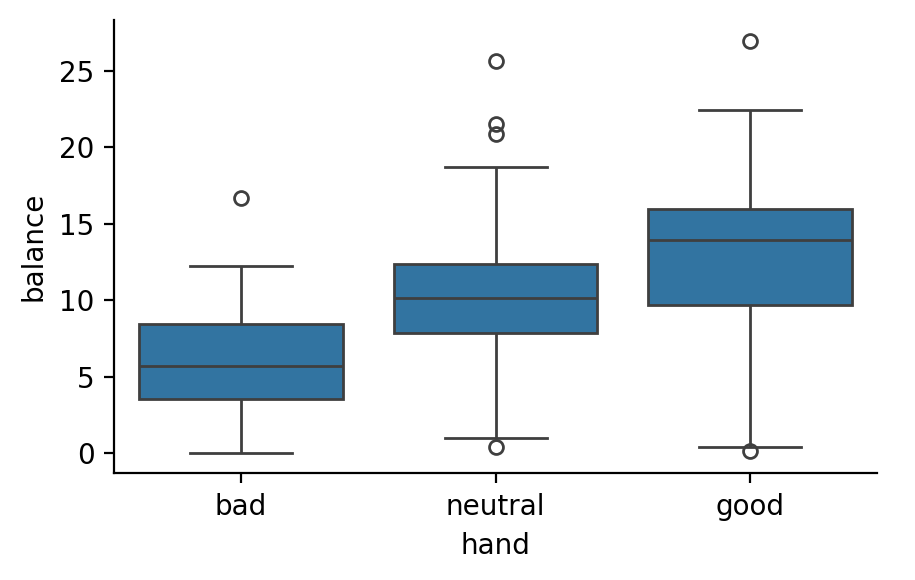

In [33]:
grid = sns.catplot(data=df, x='hand', y='balance', kind='box', height=3, aspect=1.5)

That there's a **linear trend** such that balance **increases** going from `bad` -> `neutral` -> `good`

How do we test this hypothesis? We can just create a *new* variable that treats our category levels **as if** they were a continuous variable!  

This only makes sense, if there is some *natural ordering* to the category levels because it assumes that the increment from `bad` -> `neutral` is the same as from `neutral` -> `good`. In our case this is defensible, as moving from left-to-right on the x-axis above is akin to moving along a continuous variable anchored by `bad` and `good` end-points. But this *wouldn't* make a lot of sense of our levels didn't have a natural ordering (e.g. dog, human, bird)

Concretely we're trying to estimate the *slope* of a line that connects bad -> good

We can use a little linear algebra to see what this means:

In [34]:
bad = df.filter(col('hand') == 'bad')['balance'].mean()
good = df.filter(col('hand') == 'good')['balance'].mean()
neutral = df.filter(col('hand') == 'neutral')['balance'].mean()

# Put the means of each hand level in an array ordered in the way we want
means = np.array([bad, neutral, good])

numerical_hand = np.array([-1, 0, 1])

np.dot(means, numerical_hand)

np.float64(7.084900000000006)

This captures the equivalent of a **slope** that reflect: "change in `balance`" for 1-unit change in `hand`!

Let's try to estimate this using a regression following this procedure:

1. Create a new variable that replaces levels of a categorical variable continuous values 
2. To support unbalanced data and intepretabiltiy - make sure the continuous values are *centered* at zero (just like a true continuous variable)
3. (Optional) Use *fractional* numerical values that add up to one to interpret the regression *slope* as a 1-unit change in the categorical variable
4. Run a new regression using the variable you just created with no categorical coding

Let's do that now:

In [43]:
# We can use the .replace() method to convert values of one column to new values
df = df.with_columns(
    hand_slope = col('hand').replace({'bad': -1, 'neutral': 0, 'good': 1}).cast(float)
)
df.head()

shape: (5, 5)
┌────────┬──────┬───────┬─────────┬────────────┐
│ skill  ┆ hand ┆ limit ┆ balance ┆ hand_slope │
│ ---    ┆ ---  ┆ ---   ┆ ---     ┆ ---        │
│ str    ┆ str  ┆ str   ┆ f64     ┆ f64        │
╞════════╪══════╪═══════╪═════════╪════════════╡
│ expert ┆ bad  ┆ fixed ┆ 4.0     ┆ -1.0       │
│ expert ┆ bad  ┆ fixed ┆ 5.55    ┆ -1.0       │
│ expert ┆ bad  ┆ fixed ┆ 9.45    ┆ -1.0       │
│ expert ┆ bad  ┆ fixed ┆ 7.19    ┆ -1.0       │
│ expert ┆ bad  ┆ fixed ┆ 5.71    ┆ -1.0       │
└────────┴──────┴───────┴─────────┴────────────┘

In [44]:
oneway_continuous = ols('balance ~ hand_slope', data=df.to_pandas()).fit()
print(oneway_continuous.summary(slim=True)) 

                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.329
No. Observations:                 300   F-statistic:                     147.5
Covariance Type:            nonrobust   Prob (F-statistic):           7.58e-28
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7715      0.238     41.032      0.000       9.303      10.240
hand_slope     3.5424      0.292     12.145      0.000       2.968       4.116

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


In the output above the intercept is the *grand-mean*. Why? Because out continuous variable is *centered*!

Wait, but out `hand_slope` doesn't look the value we calculated above...what's going on?

It turns out converting our categorical levels using -1, 0, 1, the regression slope is **twice as long** as we would expect if our categorical variable was a *true* continuous variable. So our our estimate slope is **half as big** as it should be.

In [45]:
oneway_continuous.params['hand_slope'] * 2

np.float64(7.084899999999991)

This **does not** affect the t-statistic and p-values of our parameter - just the estimate itself.  
To make things more interpretable the fix is easy - following step 3 above and using *fractional* values who's absolute value adds up to 1

Let's see this in code and visually:

In [46]:
# Original approach
continuous_hand = np.array([-1, 0, 1]) 

# Slope = max - min
np.max(continuous_hand) - np.min(continuous_hand)

np.int64(2)

In [47]:
# If we have to divide our estimate by 2, we can just divide the continous values by 2 instead!
lincon = continuous_hand / 2

# This is actually what we want for interpretation
lincon

array([-0.5,  0. ,  0.5])

In [48]:
# Slope is now 1 not 2
# Slope = max - min
np.max(lincon) - np.min(lincon)

np.float64(1.0)

And visually we can see over the same *range* of x-values (continuous version of `hand` levels), [-1, 0, 1], have a slope of 2 and thus produce a coefficient that's *half* as big as the value we would like

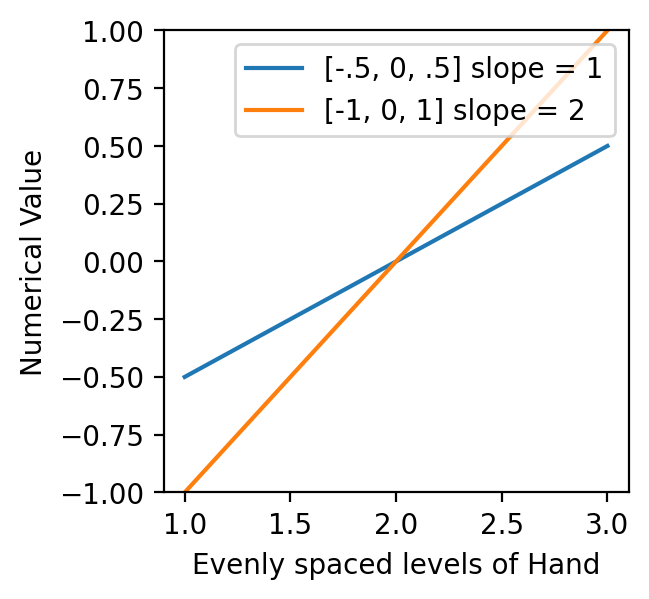

In [49]:
plt.figure(figsize=(3,3))
plt.plot([1,2,3], lincon, label='[-.5, 0, .5] slope = 1')
plt.plot([1,2,3], continuous_hand, label='[-1, 0, 1] slope = 2')
plt.ylim([-1, 1]);
plt.xlabel('Evenly spaced levels of Hand');
plt.ylabel('Numerical Value')
plt.legend();

### Challenge (mini)

Using the example and explanation above, create/replace the column we created (continuous version of `hand`) to use values that have a slope of 1.

Then use that new column to run a univariate regression. What does the parameter estimate look like now?


In [50]:
# Your code here

In [51]:
# Solution
df = df.with_columns(
    hand_slope = col('hand').replace({'bad': -.5, 'neutral': 0, 'good': .5}).cast(float)
)
df.head()

shape: (5, 5)
┌────────┬──────┬───────┬─────────┬────────────┐
│ skill  ┆ hand ┆ limit ┆ balance ┆ hand_slope │
│ ---    ┆ ---  ┆ ---   ┆ ---     ┆ ---        │
│ str    ┆ str  ┆ str   ┆ f64     ┆ f64        │
╞════════╪══════╪═══════╪═════════╪════════════╡
│ expert ┆ bad  ┆ fixed ┆ 4.0     ┆ -0.5       │
│ expert ┆ bad  ┆ fixed ┆ 5.55    ┆ -0.5       │
│ expert ┆ bad  ┆ fixed ┆ 9.45    ┆ -0.5       │
│ expert ┆ bad  ┆ fixed ┆ 7.19    ┆ -0.5       │
│ expert ┆ bad  ┆ fixed ┆ 5.71    ┆ -0.5       │
└────────┴──────┴───────┴─────────┴────────────┘

In [52]:
# Solution
oneway_continuous = ols('balance ~ hand_slope', data=df.to_pandas()).fit()
print(oneway_continuous.summary(slim=True)) 

                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.329
No. Observations:                 300   F-statistic:                     147.5
Covariance Type:            nonrobust   Prob (F-statistic):           7.58e-28
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7715      0.238     41.032      0.000       9.303      10.240
hand_slope     7.0849      0.583     12.145      0.000       5.937       8.233

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


### Comparison to Polynomial Coding

It turns out that this is what polynomial coding is doing when we use `C(hand, Poly)`! Technically, it estimates all possible polynomials (linear, quadratic, cubic, etc.), but let's just focus on the linear one to build our intuition:

In [53]:
poly_model = ols('balance ~ C(hand, Poly)', data=df.to_pandas())
poly_fit = poly_model.fit()

poly_fit.params

Intercept                  9.771500
C(hand, Poly).Linear       3.114876
C(hand, Poly).Quadratic   -3.986422
dtype: float64

We're going to manually create the polynomial contrasts like `ols` does for us and then use the *same approach* as earlier to replace our categorical variable with a new continuous one:

In [54]:
from patsy.contrasts import Poly

# Levels in the order they appear by default in the model
levels = ['bad', 'good','neutral']

# Generate a matrix using our predictor variables
# These are the comparisons our parameters above reflect!
poly_codes = Poly().code_without_intercept(levels)


poly_codes.column_suffixes
poly_codes.matrix

['.Linear', '.Quadratic']

array([[-7.07106781e-01,  4.08248290e-01],
       [-1.69402794e-17, -8.16496581e-01],
       [ 7.07106781e-01,  4.08248290e-01]])

Let's just grab the linear one:

In [55]:
poly_lincon = poly_codes.matrix[:,0]

And then replace our factor levels with it:

In [56]:
df = df.with_columns(
    hand_poly_Linear = col('hand').replace({
        'bad': poly_lincon[0], 
        'good': poly_lincon[1],
        'neutral': poly_lincon[2]
    }).cast(float)
)

ols('balance ~ hand_poly_Linear', data=df.to_pandas()).fit().params

Intercept           9.771500
hand_poly_Linear    3.114876
dtype: float64

And we can see that our "continu-fied" version of `hand`, using the same continuous values that Poly used, produces the same (linear) parameter estimate!

In [57]:
poly_fit.params

Intercept                  9.771500
C(hand, Poly).Linear       3.114876
C(hand, Poly).Quadratic   -3.986422
dtype: float64

## Wrap-up Challenge


### 1. 

Your colleage has estimated the following model and is very excited about the significant result on the parameter estimate `skill_con` below. Leveraging what you've learned about continuous and categorical predictors, help them understand it by answering the following questions:

1. What does the parameter estimate represent?
2. How does it affect the interpretation of the `hand_lincon:skill_con` interaction estimate?
3. Does this estimate test the difference they intended to test? Why or why not?

Use any coding/visualization approach you would like to support your answers

*Your response here*

In [58]:
# Your colleague's code - you can just run this cell
df = df.with_columns(
    hand_lincon = col('hand').replace({
        'bad': 1,
        'neutral': 2,
        'good': 3
    }).cast(float),
    skill_con = col('skill').replace({
        'average': .5,
        'expert': -.5
    }).cast(float)
)

model_h = ols('balance ~ hand_lincon * skill_con', data=df.to_pandas()).fit()
print(model_h.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.360
No. Observations:                 300   F-statistic:                     56.99
Covariance Type:            nonrobust   Prob (F-statistic):           4.17e-29
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.6866      0.615      4.365      0.000       1.475       3.898
hand_lincon               3.5424      0.285     12.434      0.000       2.982       4.103
skill_con                -4.9765      1.231     -4.043      0.000      -7.399      -2.554
hand_lincon:skill_con     2.1261      0.570      3.731      0.000       1.005       3.247

Notes:
[1] Standard Errors assume that the covariance matrix of 

In [ ]:
# Your code here

In [ ]:
# Solution
# It represents the slope of skill when hand_lincon is 0

# Get predictions when hand_lincon is 0 to verify
hand_lincon = np.repeat(0, df.height)
skill_con = df['skill_con'].to_numpy()
preds = model_h.predict({'hand_lincon': hand_lincon, 'skill_con': skill_con})

# Fit model and grab skill_con coefficient
ols('preds ~ skill_con', data=pl.DataFrame({'preds': preds, 'skill_con': skill_con})).fit().params['skill_con']



np.float64(-4.976533333333325)

### 2. 

Fix your colleague's work by estimating a new *multiple regression* using **continous** versions of `skill`, `hand`, *and* their interaction. Create your new variables to test:

  - a linear contrast of `hand`, such that balance increases from `bad` -> `neutral` -> `good`
  - a linear contrast of `skill` such that balance increases from `average` -> `expert`

Verify that your parameter estimate reflect the hypothesis you expect by using the means of each factor level like we've demonstrated in this notebook

How do these estimates compare to the ones your colleage got above?

In [ ]:
# Your code here

In [66]:
# Solution
df = df.with_columns(
    hand_lincon = col('hand').replace({
        'bad': -.5,
        'neutral': 0,
        'good': .5
    }).cast(float),
    skill_con = col('skill').replace({
        'average': .5,
        'expert': -.5
    }).cast(float)
)

model_h = ols('balance ~ hand_lincon * skill_con', data=df.to_pandas()).fit()
print(model_h.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.360
No. Observations:                 300   F-statistic:                     56.99
Covariance Type:            nonrobust   Prob (F-statistic):           4.17e-29
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.7715      0.233     42.008      0.000       9.314      10.229
hand_lincon               7.0849      0.570     12.434      0.000       5.964       8.206
skill_con                -0.7243      0.465     -1.557      0.121      -1.640       0.191
hand_lincon:skill_con     4.2522      1.140      3.731      0.000       2.010       6.495

Notes:
[1] Standard Errors assume that the covariance matrix of 

In [67]:
# Solution
expert = df.filter(col('skill') == 'expert')['balance'].mean()
average = df.filter(col('skill') == 'average')['balance'].mean()

bad = df.filter(col('hand') == 'bad')['balance'].mean()
neutral = df.filter(col('hand') == 'neutral')['balance'].mean()
good = df.filter(col('hand') == 'good')['balance'].mean()

In [69]:
# skill_con is the same as expert - average

# The dot product calculates this:
# -1 * expert + 1 * average
np.dot([expert, average], [-1, 1])

np.float64(-0.7243333333333322)

In [70]:
# hand_lincon is the linear trend from bad -> neutral -> good

# The dot product calculates this:
# -1 * bad + 0 * netural + 1 * good
np.dot([bad, neutral, good], [-1, 0, 1])

np.float64(7.084899999999999)

We can think about the interaction as difference-of-differences in 2 ways:

1. The difference between `skill` differences at each level of `hand`

In [71]:
average_hands = cell_means.filter(col('skill') == 'average')
average_hands


shape: (3, 3)
┌─────────┬─────────┬─────────┐
│ hand    ┆ skill   ┆ balance │
│ ---     ┆ ---     ┆ ---     │
│ str     ┆ str     ┆ f64     │
╞═════════╪═════════╪═════════╡
│ bad     ┆ average ┆ 4.5866  │
│ good    ┆ average ┆ 13.7976 │
│ neutral ┆ average ┆ 9.8438  │
└─────────┴─────────┴─────────┘

In [72]:
expert_hands = cell_means.filter(col('skill') == 'expert')
expert_hands


shape: (3, 3)
┌─────────┬────────┬─────────┐
│ hand    ┆ skill  ┆ balance │
│ ---     ┆ ---    ┆ ---     │
│ str     ┆ str    ┆ f64     │
╞═════════╪════════╪═════════╡
│ bad     ┆ expert ┆ 7.2964  │
│ good    ┆ expert ┆ 12.2552 │
│ neutral ┆ expert ┆ 10.8494 │
└─────────┴────────┴─────────┘

In [73]:
hands_diffs = (average_hands['balance'] - expert_hands['balance']).to_numpy()

# Rearrange the hand levels into [bad, neutral, good] order  
hands_diffs = np.array([hands_diffs[0], hands_diffs[2], hands_diffs[1]])

# Linear contrast across differences
np.dot(hands_diffs, [-1, 0, 1])

np.float64(4.252199999999996)

2. The difference between `hand` differences at each level of `skill`

In [74]:
# Below we create [expert, average] array for each hand level
bad_skill = cell_means.filter(col('hand') == 'bad').sort(by='skill', descending=True)['balance'].to_numpy()

neutral_skill = cell_means.filter(col('hand') == 'neutral').sort(by='skill', descending=True)['balance'].to_numpy()

good_skill = cell_means.filter(col('hand') == 'good').sort(by='skill', descending=True)['balance'].to_numpy()

In [75]:
# E.g.
bad_skill

array([7.2964, 4.5866])

In [76]:
# Stack into 2 (skill) x 3 (hand) arrray
# in the order of hand levels we want to test
skills = np.column_stack([bad_skill, neutral_skill, good_skill])
skills

array([[ 7.2964, 10.8494, 12.2552],
       [ 4.5866,  9.8438, 13.7976]])

In [94]:
# Calculate the linear contrast
lin_con = np.dot(skills, [-1, 0, 1])
lin_con

array([4.9588, 9.211 ])

In [97]:
# And the difference between those
lin_con[1] - lin_con[0]

np.float64(4.252199999999995)